In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Load and preprocess data

In [2]:
# Load and preprocess data
def prepare_data(df, feature_col='Open', seq_length=10):
    scaler = MinMaxScaler()
    df[feature_col] = scaler.fit_transform(df[[feature_col]])
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_col].iloc[i:i+seq_length].values)
        y.append(df[feature_col].iloc[i+seq_length])
    
    return np.array(X), np.array(y), scaler

## Load data

In [3]:
df = pd.read_csv("NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

## Prepare dataset

In [4]:
seq_length = 10  # Number of days for LSTM input
X, y, scaler = prepare_data(df, feature_col='Open', seq_length=seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM

# Convert to PyTorch tensors

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

## Train-Test-Validation Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Create DataLoader

In [7]:
batch_size = 16
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Define LSTM model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

## Initialize model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

## Define loss and optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop with validation

In [12]:
epochs = 50
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


Epoch 1/50, Train Loss: 0.004889, Val Loss: 0.000169
Epoch 2/50, Train Loss: 0.000302, Val Loss: 0.000165
Epoch 3/50, Train Loss: 0.000284, Val Loss: 0.000087
Epoch 4/50, Train Loss: 0.000330, Val Loss: 0.000077
Epoch 5/50, Train Loss: 0.000241, Val Loss: 0.000222
Epoch 6/50, Train Loss: 0.000247, Val Loss: 0.000095
Epoch 7/50, Train Loss: 0.000255, Val Loss: 0.000172
Epoch 8/50, Train Loss: 0.000304, Val Loss: 0.000149
Epoch 9/50, Train Loss: 0.000218, Val Loss: 0.000077
Epoch 10/50, Train Loss: 0.000251, Val Loss: 0.000068
Epoch 11/50, Train Loss: 0.000215, Val Loss: 0.000051
Epoch 12/50, Train Loss: 0.000221, Val Loss: 0.000086
Epoch 13/50, Train Loss: 0.000196, Val Loss: 0.000349
Epoch 14/50, Train Loss: 0.000230, Val Loss: 0.000051
Epoch 15/50, Train Loss: 0.000162, Val Loss: 0.000069
Epoch 16/50, Train Loss: 0.000150, Val Loss: 0.000042
Epoch 17/50, Train Loss: 0.000157, Val Loss: 0.000045
Epoch 18/50, Train Loss: 0.000148, Val Loss: 0.000109
Epoch 19/50, Train Loss: 0.000170, Va

### Save model

In [ ]:
# torch.save(model.state_dict(), "lstm_nvidia_model.pth")
torch.save(model.state_dict(), "lstm_nvidia_model2.pth")

## Plot training and validation loss

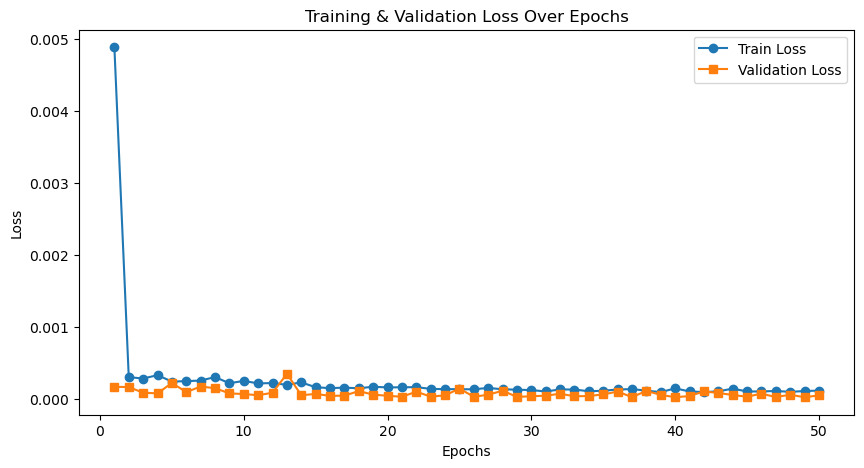

In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()

## Load trained model

In [11]:

model.load_state_dict(torch.load(r"C:\Users\dheen\deep_learning_spring_2024_group_4\deep_learning_spring_2025_group_4\new\lstm_nvidia_model.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Predictions

In [12]:
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

## Convert to original scale

In [13]:
predictions = scaler.inverse_transform(np.vstack(predictions))
actuals = scaler.inverse_transform(np.vstack(actuals))

## Plot actual vs predicted with transparency

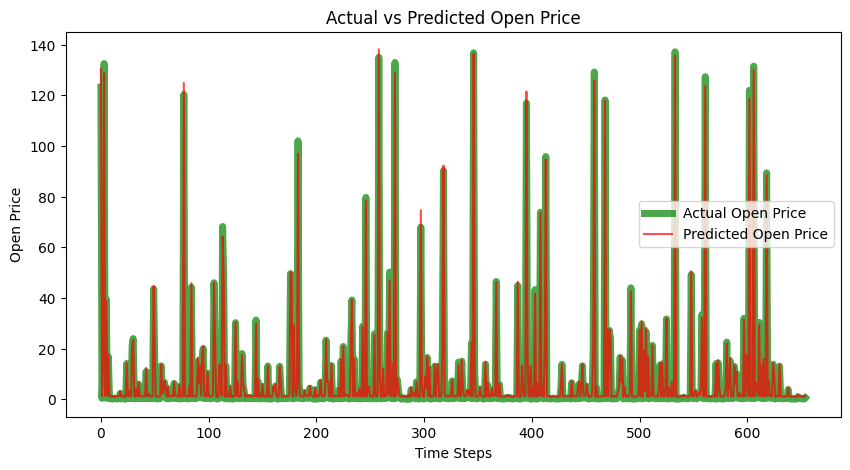

In [14]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.7,linewidth=5)  # Added alpha for transparency
plt.plot(predictions, label='Predicted Open Price', color='r', alpha=0.7)  # Added alpha for transparency
plt.legend()
plt.title("Actual vs Predicted Open Price")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

## Model evaluation

In [15]:
mse = np.mean((actuals - predictions) ** 2)
mae = np.mean(np.abs(actuals - predictions))
print(f"Test MSE: {mse:.6f}, Test MAE: {mae:.6f}")

Test MSE: 1.107121, Test MAE: 0.883744


## Identify failure cases

In [16]:
error_threshold = np.percentile(np.abs(actuals - predictions), 90)
failure_cases = np.where(np.abs(actuals - predictions) > error_threshold)[0]

## Failure Cases in Predictions

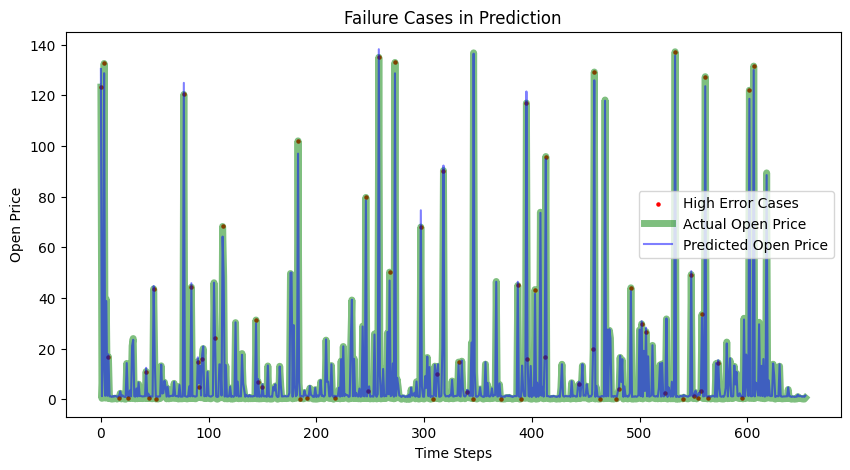

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(failure_cases, actuals[failure_cases], color='r', label='High Error Cases',s=5)
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.5, linewidth=5)
plt.plot(predictions, label='Predicted Open Price', color='b', alpha=0.5)
plt.legend()
plt.title("Failure Cases in Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

In [18]:
for idx in failure_cases:
    print(f"Failure Case {idx}:")
    print(f"Input Sequence: {X[idx]}")
    print(f"Actual: {actuals[idx]}, Predicted: {predictions[idx]}")

Failure Case 0:
Input Sequence: [[5.78711203e-05]
 [6.12764646e-05]
 [7.14859352e-05]
 [4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]]
Actual: [123.240005], Predicted: [130.41571]
Failure Case 3:
Input Sequence: [[4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]
 [3.82953369e-05]
 [4.34000754e-05]
 [3.74456299e-05]]
Actual: [132.58], Predicted: [128.74802]
Failure Case 7:
Input Sequence: [[3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]
 [3.82953369e-05]
 [4.34000754e-05]
 [3.74456299e-05]
 [2.21248912e-05]
 [2.04254708e-05]
 [4.42563054e-05]
 [6.12764646e-05]]
Actual: [16.788], Predicted: [17.741646]
Failure Case 17:
Input Sequence: [[5.10604383e-05]
 [5.10604383e-05]
 [4.42563054e-05]
 [6.12764646e-05]
 [6.46818024e-05]
 [1.15742267e-04]
 [1.08938108e-04]
 [8.85126370e-05]
 [7.82966172e-05]
 [7.14859352e-05]]
Actual: [0.56925], P

In [41]:
import shap
from shap import KernelExplainer

failure_X = X_tensor[failure_cases].to(device)  # Ensure the tensor is moved to the same device as the model

# Define a wrapper function for the model
def model_predict(inputs):
    # Convert NumPy array to PyTorch tensor
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(inputs_tensor).cpu().numpy()  # Ensure outputs are moved to CPU and converted to numpy
    return outputs

# Temporarily set the model to training mode for SHAP explanation
was_training = model.training  # Save the current training state
model.train()  # Ensure the model is in training mode
explainer = shap.DeepExplainer(model, X_tensor[:100].to(device))  # Use a subset of data as background
shap_values = explainer.shap_values(failure_X)
if not was_training:
    model.eval()  # Revert back to evaluation mode only if it was not in training mode before

# Convert SHAP values and input data to numpy for plotting
shap_values_numpy = np.array(shap_values)  # Convert SHAP values to numpy
failure_X_numpy = failure_X.cpu().numpy()  # Convert input data to numpy

# Ensure SHAP values are reshaped to 2D if necessary
if shap_values_numpy.ndim > 2:
    shap_values_numpy = shap_values_numpy.reshape(shap_values_numpy.shape[0], -1)

# Plot SHAP summary
shap.summary_plot(
    shap_values_numpy, 
    failure_X_numpy, 
    feature_names=[f"Day {i+1}" for i in range(seq_length)], 
    plot_type="bar"
)

RuntimeError: cudnn RNN backward can only be called in training mode